# Lets Grow More Data Science Internship 

### Author: Settara Pramod

# Task - 2 Stock Market Prediction and Forecasting using Stacked LSTM

## Importing required Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.utils.vis_utils import plot_model


%matplotlib inline

## Importing NSE-TATAGLOBAL Dataset

In [2]:
data = pd.read_csv('NSE-TATAGLOBAL.csv')

In [3]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


## Checking for Missing values

In [4]:
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

## Basic Information about the Dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [6]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


## Formating the Date datatype from object to Datetime and making it as index

In [7]:
data["Date"]=pd.to_datetime(data.Date)
data.index=data['Date']

In [8]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-09-28,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


## Plotting the Closing value

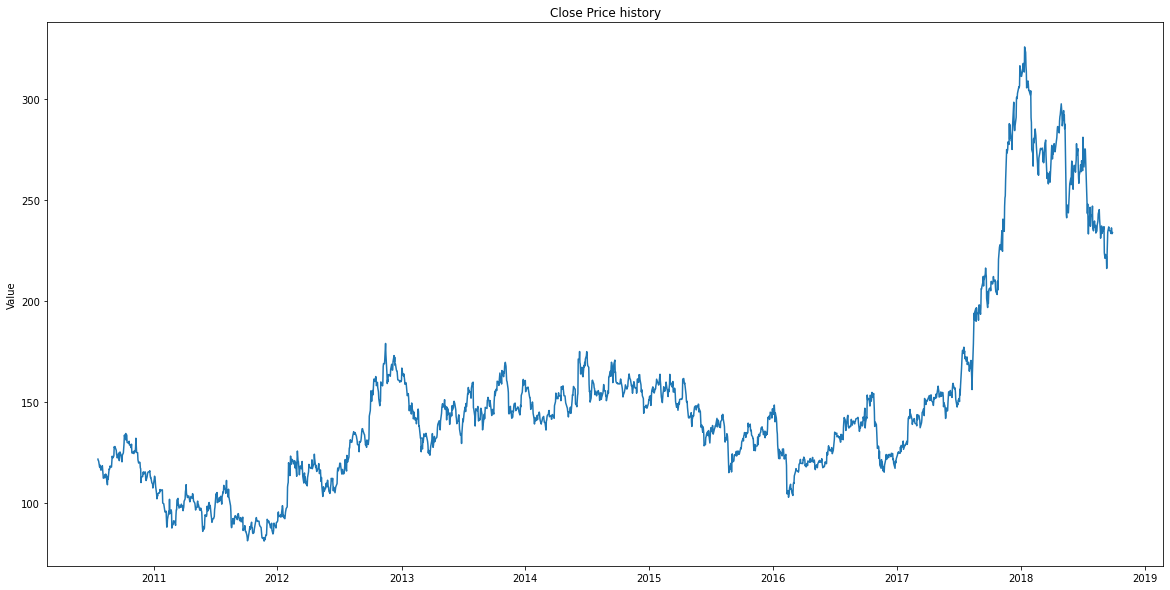

In [9]:
plt.figure(figsize=(20,10))
plt.title('Close Price history')
plt.ylabel("Value")
plt.plot(data["Close"])

## Making new data set only with Close Value 

In [10]:
data_sort=data.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(data)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [11]:
data_sort.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2010-07-21,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [12]:
df = new_dataset
new_dataset.head()

,Date,Close
0,2018-09-28 00:00:00,233.75
1,2018-09-27 00:00:00,233.25
2,2018-09-26 00:00:00,234.25
3,2018-09-25 00:00:00,236.1
4,2018-09-24 00:00:00,233.3


In [13]:
new_dataset.index=new_dataset.Date
new_dataset.sort_index(ascending=True,inplace=True)
new_dataset.drop("Date",axis=1,inplace=True)

## Preprocessing the dataset

In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset=scaler.fit_transform(np.array(new_dataset).reshape(-1,1))

In [15]:
new_dataset

array([[0.16584967],
       [0.16319444],
       [0.1621732 ],
       ...,
       [0.62622549],
       [0.62214052],
       [0.62418301]])

## Splitting the dataset fot Training and Testing 

In [16]:
training_size=int(len(new_dataset)*0.85)
test_size=len(new_dataset)-training_size
train_data,test_data=new_dataset[0:training_size,:],new_dataset[training_size:len(new_dataset),:1]

## Converting an array of values into a Dataset Matrix

In [17]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print('Training Data',X_train.shape,y_train.shape)

Training Data (1628, 100) (1628,)


In [20]:
print('Training Data',X_test.shape,ytest.shape)

Training Data (205, 100) (205,)


In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Stacked LSTM Model

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


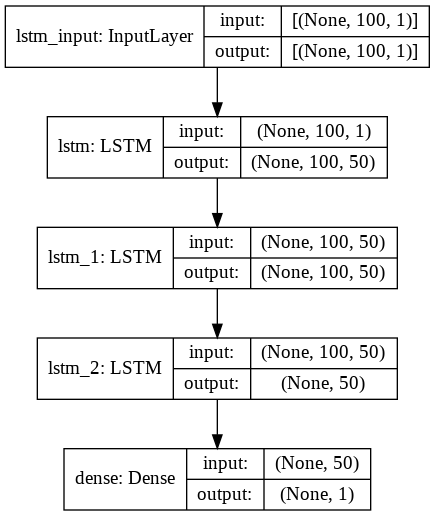

In [24]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=30,batch_size=64,verbose=2)

Epoch 1/30
26/26 - 11s - loss: 0.0079 - val_loss: 0.0413
Epoch 2/30
26/26 - 4s - loss: 0.0014 - val_loss: 0.0073
Epoch 3/30
26/26 - 4s - loss: 8.9027e-04 - val_loss: 0.0085
Epoch 4/30
26/26 - 4s - loss: 8.3485e-04 - val_loss: 0.0057
Epoch 5/30
26/26 - 4s - loss: 7.8397e-04 - val_loss: 0.0076
Epoch 6/30
26/26 - 4s - loss: 7.5426e-04 - val_loss: 0.0047
Epoch 7/30
26/26 - 4s - loss: 7.0920e-04 - val_loss: 0.0040
Epoch 8/30
26/26 - 4s - loss: 7.1075e-04 - val_loss: 0.0028
Epoch 9/30
26/26 - 4s - loss: 7.1068e-04 - val_loss: 0.0084
Epoch 10/30
26/26 - 4s - loss: 6.0697e-04 - val_loss: 0.0092
Epoch 11/30
26/26 - 4s - loss: 5.6113e-04 - val_loss: 0.0098
Epoch 12/30
26/26 - 4s - loss: 5.3125e-04 - val_loss: 0.0085
Epoch 13/30
26/26 - 4s - loss: 5.1922e-04 - val_loss: 0.0124
Epoch 14/30
26/26 - 4s - loss: 4.9262e-04 - val_loss: 0.0161
Epoch 15/30
26/26 - 4s - loss: 5.1546e-04 - val_loss: 0.0168
Epoch 16/30
26/26 - 4s - loss: 4.8326e-04 - val_loss: 0.0134
Epoch 17/30
26/26 - 4s - loss: 5.2094e-0

## Predicting the Values

In [26]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Calculating RMSE 

In [28]:
print('RMSE on Train Dataset:',math.sqrt(mean_squared_error(y_train,train_predict)))
print('RMSE on Test  Dataset:',math.sqrt(mean_squared_error(ytest,test_predict)))

RMSE on Train Dataset: 135.99313629659034
RMSE on Test  Dataset: 256.23372924311116


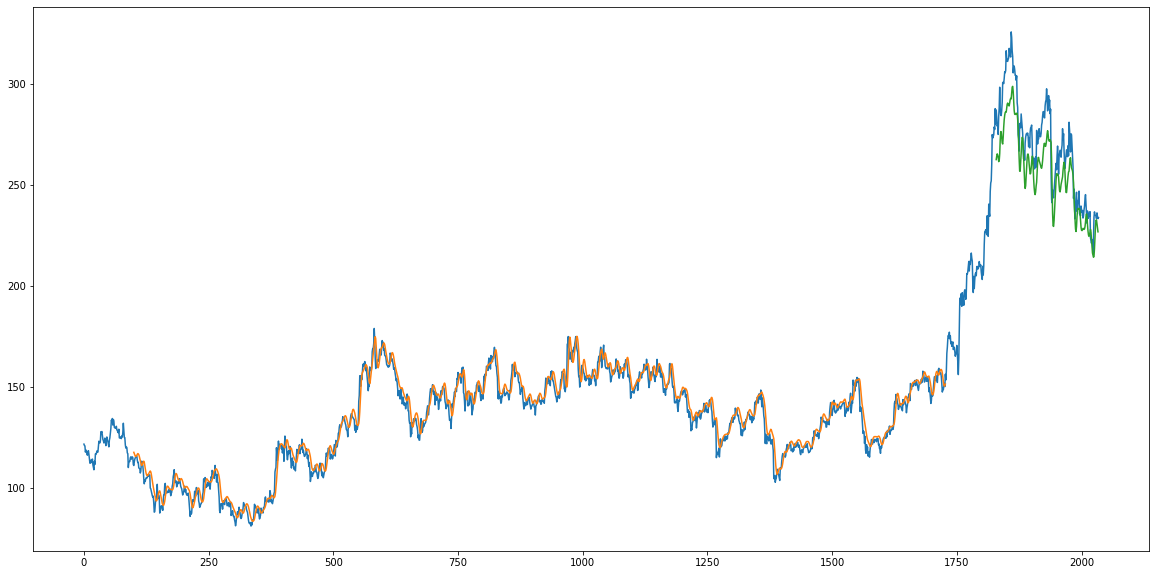

In [29]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(new_dataset)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(new_dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()